In [59]:
#1) for hurricane dictionary
#https://www.nhc.noaa.gov/data/hurdat/hurdat2-format-atl-1851-2021.pdf schema


#2) for download image data
#https://oceancolor.gsfc.nasa.gov/data/download_methods/#appkey
apiKey = '?appkey=5c78cd36e3946b34e84f0e6024d31e377051b942'

# wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --content-disposition https://oceandata.sci.gsfc.nasa.gov/ob/getfile/T2017004001500.L1A_LAC.bz2?appkey=5c78cd36e3946b34e84f0e6024d31e377051b942 --no-check-certificate

import urllib.request as urllib2
#open url
target_url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2021-041922.txt'
data = urllib2.urlopen(target_url)


#read hurricane file into a dictionary  keyed by ID
hurricane_dict = {}
curr_hurricane = None
for line in data: 
    line = line.decode('utf-8').replace(' ', '')
    arr = line.split(',')
    
    if len(arr) == 4:  # hurricane names add a new hurricane
        if arr[1] in hurricane_dict.keys():
            print ('duplicate hurricane dropped', arr[1])
            continue
        hurricane_dict[arr[0]] = {'id': arr[0], 'name': arr[1], 'num_of_records': int(arr[2]), 'path': []}
        curr_hurricane = arr[0]
    elif len(arr) > 4:
        rec = {'date': int(arr[0]), 'time': arr[1], 'category':arr[3],
               'lt':arr[4], 'lg':arr[5], 'maxwind':arr[6], 'maxpres':arr[7],
              '34ktne':arr[8], '34ktse':arr[9], '34ktsw':arr[9], '34ktnw':arr[10],
              '50ktne':arr[11], '50ktse':arr[12], '50ktsw':arr[13], '50ktnw':arr[14], 
               '64ktne':arr[15], '64ktse':arr[16], '64ktsw':arr[17], '64ktnw':arr[18], 
               'maxwindradius':arr[19]
              }
        hurricane_dict[curr_hurricane]['path'].append(rec)
    

In [42]:
#test hdf5 imerg

#imerg_df = pd.read_hdf('/home/fun/data/imerg/3B-HHR.MS.MRG.3IMERG.20121021-S023000-E025959.0150.V06B.HDF5')  

import h5py

f = h5py.File('/home/fun/data/imerg/3B-HHR.MS.MRG.3IMERG.20121021-S023000-E025959.0150.V06B.HDF5', 'r')

for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key])) # get the object type: usually group or dataset
    
#Get the HDF5 group; key needs to be a group name from above
group = f['Grid']

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)
    
longitude = group['lon'][()] # len 3600, x-axis
latitude = group['lat'][()] # len 1800, y-axis
rain = group['precipitationCal'][()] # array of shape (1, 3600, 1800)

lon = -77.4
lat = 14.3

print(latitude, clos_coords)
i = int((lat-latitude[0])*10)
j = int((lon-longitude[0])*10)
print(latitude[i], longitude[j])

rain = rain.reshape(3600, 1800)
rain[i][j]

Grid
<class 'h5py._hl.group.Group'>
nv
lonv
latv
time
lon
lat
time_bnds
lon_bnds
lat_bnds
precipitationCal
precipitationUncal
randomError
HQprecipitation
HQprecipSource
HQobservationTime
IRprecipitation
IRkalmanFilterWeight
probabilityLiquidPrecipitation
precipitationQualityIndex
[-89.95 -89.85 -89.75 ...  89.75  89.85  89.95] [14.25, -77.45]
14.25 -77.45


0.23560527

In [80]:
#3) generate data holders for each hurriacne

import json
import os
count = 0
for key, val in hurricane_dict.items():

    if val['path'][0]['date'] >= 19970101:

        directory = '/home/fun/data/' + str(key)
        os.makedirs(directory)

        filename = '/home/fun/data/' + str(key) + '/profile.json'
        out_file = open(filename, "x")

        json.dump(hurricane_dict[key], out_file, indent = 6)
        out_file.close()

In [2]:
#5 generate dataframe for rain data on huriacane path
#step 2 by location
# for every time stamp, the satellite takes an image in a large cone with 7x7 spatial resolution
#step 2 by location
# for every time stamp, the satellite takes an image in a large cone with 7x7 spatial resolution.
import numpy as np
import glob
import h5py

def search_location_in_hdf(filename, n, m, results_dict):
    hdf = SD.SD(filename) # first day of hurricane sandy
    v_scanTime = hdf.select('scanTime_sec')
    v_rain = hdf.select('rain')
    v_lat = hdf.select('Latitude')
    v_long = hdf.select('Longitude')
    lat_delta = 0.05
    long_delta = 0.02

    lav = v_lat.get()
    lgv = v_long.get()

    results = []
    for i in range(len(lav)): # filter first by closest latitude
        lat = lav[i]    
        lg = lgv[i]

        if (abs(lat[0] -n) < lat_delta * 49) and (abs(lg[0] -m) < long_delta *49):
            results.append(i)
    
    results_dict[filename] = results
    
                
#             long = v_long.get()[i]
#             clos_coords = pd.DataFrame([(lat, long, i)], columns = ['Latitude', 'Longitude', 'Index'])
#             closest = pd.concat([closest, clos_coords], ignore_index = True)

results={}
for name in glob.glob('/home/fun/data/AL182012/*.HDF'):
    print(name)
    search_location_in_hdf(name, 14.3, -77.4, results)

print (results)

#result_index = closest['Longitude'].sub(long).abs().idxmin() # then filter by closest longitude
# result is the index of the location that most closely matches the desired coordinates
# index represents the index in the original list when looking at the rain_type array

/home/fun/data/AL182012/2A25.20121021.85054.7.HDF


NameError: name 'SD' is not defined

In [248]:

df = pd.DataFrame()

for key, val in results.items():
    indices = []
    if len(val) > 0: # corresponds to one file
        hdf = SD.SD(key) # first day of hurricane sandy
        v_scanTime = hdf.select('scanTime_sec')
        v_rain = hdf.select('nearSurfRain')
        v_lat = hdf.select('Latitude')
        v_long = hdf.select('Longitude')
        indices.extend(val)
        
        for i in val:
            df_temp = pd.DataFrame({'scanTime': v_scanTime[i], 'Latitude':v_lat[i],'Longitude': v_long[i], 'nearSurfRain': v_rain[i], 'Index': i})
            df = pd.concat([df, df_temp])

In [250]:
df

,scanTime,Latitude,Longitude,nearSurfRain,Index
0,5788.947416,15.300453,-78.351288,0.0,6279
1,5788.947416,15.259553,-78.378487,0.0,6279
2,5788.947416,15.218772,-78.405525,0.0,6279
3,5788.947416,15.178164,-78.432381,0.0,6279
4,5788.947416,15.138129,-78.458794,0.0,6279
...,...,...,...,...,...
44,56028.588455,14.664925,-75.332077,0.0,3019
45,56028.588455,14.625157,-75.305099,0.0,3019
46,56028.588455,14.585091,-75.277893,0.0,3019
47,56028.588455,14.544387,-75.250237,0.0,3019


In [264]:
df_rain = df[df.nearSurfRain > 0]
df_rain.describe()

,scanTime,Latitude,Longitude,nearSurfRain,Index
count,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000
mean,53200.580412,14.719081,-77.010071,3.823310,3170.897228
std,11537.356846,0.766643,0.658270,6.035595,765.401304
min,5788.947416,12.204543,-79.276886,0.213903,2958.000000
25%,55998.017338,14.108771,-77.456602,0.990102,2970.000000
50%,56004.610777,14.682339,-77.013695,1.969690,2982.000000
75%,56016.599628,15.346102,-76.544134,3.930582,3006.000000
max,56028.588455,16.361473,-75.372787,62.155045,6340.000000


In [275]:
# 22nd, 3:30 PM
df_rain[abs(df_rain.Latitude)-]

,scanTime,Latitude,Longitude,nearSurfRain,Index
0,56011.803951,15.780039,-77.335594,2.303281,2991
0,56012.403656,15.800947,-77.303711,1.975756,2992
0,56013.003365,15.821825,-77.271866,2.542556,2993
1,56013.003365,15.780464,-77.245392,1.323320,2993
0,56013.602406,15.842664,-77.240005,1.079056,2994
...,...,...,...,...,...
11,56028.588455,15.920274,-76.164734,1.921305,3019
12,56028.588455,15.881617,-76.139694,2.761133,3019
13,56028.588455,15.842806,-76.114525,1.733258,3019
14,56028.588455,15.804648,-76.089722,1.237890,3019


In [21]:
rain_one = v1.get()[0].reshape(49, 1)
long_one = v_long.get()[0].reshape(49, 1)
lat_one = v_lat.get()[0].reshape(49, 1)

data_one = rain_one
data_one = np.append(data_one, long_one, axis = 1)
data_one = np.append(data_one, lat_one, axis = 1)

data_one_df = pd.DataFrame(data_one, columns = ['rain', 'longitude', 'latitude'])

data_one_df.plot(x="longitude", y="latitude", kind="scatter", c="rain",
        colormap="cividis")

plt.show()

NameError: name 'v1' is not defined

In [94]:
rain_flat = v1.get().reshape(453152, 1)
long_flat = v_long.get().reshape(453152, 1)
lat_flat = v_lat.get().reshape(453152, 1)

data_whole = rain_flat
data_whole = np.append(data_whole, long_flat, axis = 1)
data_whole = np.append(data_whole, lat_flat, axis = 1)

data_whole_df = pd.DataFrame(data, columns = ['rain', 'longitude', 'latitude'])

data_whole_df.plot(x="longitude", y="latitude", kind="scatter", c="rain",
        colormap="cividis")

ValueError: cannot reshape array of size 36252160 into shape (453152,1)

In [73]:
data_whole_df

,rain,longitude,latitude
0,-88.0,115.951393,-36.244316
1,-88.0,115.953636,-36.194519
2,300.0,115.955818,-36.144905
3,-88.0,115.957932,-36.095535
4,-88.0,115.959984,-36.046902
...,...,...,...
453147,-88.0,92.340378,-34.186306
453148,-88.0,92.340347,-34.137554
453149,-88.0,92.340263,-34.088417
453150,-88.0,92.340118,-34.038483


In [106]:
n = 14.3
m = -77.4
lat = v_lat.get()[5770]
long = v_long.get()[5770]
clos_coords = pd.DataFrame(np.asarray([min(lat, key=lambda x: abs(x-n)), min(long, key=lambda x: abs(x-m))]).reshape(1, 2))
clos_coords

,0,1
0,23.16469,-72.865173


Coarse Resolution Surface Reflectance Band 1
Coarse Resolution Surface Reflectance Band 2
Coarse Resolution Surface Reflectance Band 3
Coarse Resolution Surface Reflectance Band 4
Coarse Resolution Surface Reflectance Band 5
Coarse Resolution Surface Reflectance Band 6
Coarse Resolution Surface Reflectance Band 7
Coarse Resolution Solar Zenith Angle
Coarse Resolution View Zenith Angle
Coarse Resolution Relative Azimuth Angle
Coarse Resolution Ozone
Coarse Resolution Brightness Temperature Band 20
Coarse Resolution Brightness Temperature Band 21
Coarse Resolution Brightness Temperature Band 31
Coarse Resolution Brightness Temperature Band 32
Coarse Resolution Granule Time
Coarse Resolution Band 3 Path Radiance
Coarse Resolution QA
Coarse Resolution Internal CM
Coarse Resolution State QA
Coarse Resolution Number Mapping
number of 500m pixels averaged b3-7
number of 500m rej. detector
number of 250m pixels averaged b1-2
n pixels averaged


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3600, 7200)


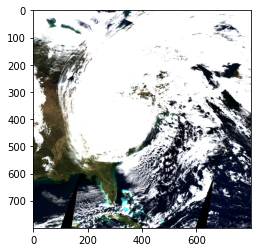

In [1]:
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt


def getTgtArea(rgb, lon, lat, radias):
    n = 3600
    m = 7200
    
    interval = 180.0 / n
    
    lat_index = int((90 - lat) / interval)
    long_index = int((lon + 180) / interval)
    
    n_raidus = int(radias / interval)
    
    
    return rgb[lat_index - n_raidus:lat_index + n_raidus, long_index - n_raidus:long_index + n_raidus]
  

hdf = SD('/home/fun/scripts/MOD09CMG.A2012304.006.2015251060001.hdf') # first day of hurricane sandy

for it in hdf.datasets():
    print (it)


R = hdf.select('Coarse Resolution Surface Reflectance Band 1').get()
B = hdf.select('Coarse Resolution Surface Reflectance Band 3').get()
G = hdf.select('Coarse Resolution Surface Reflectance Band 4').get()



R_true = R * 0.0004
G_true = G * 0.0004
B_true = B * 0.0004

rgb = np.dstack([R_true, G_true, B_true])

print (B.shape)


#top-left -180LONG, 90LAT



plt.figure()
plt.imshow(getTgtArea(rgb, -75.4, 40.3, 20))
#plt.imshow(rgb)
#plt.imshow(T20)

plt.show()





(3600, 7200)


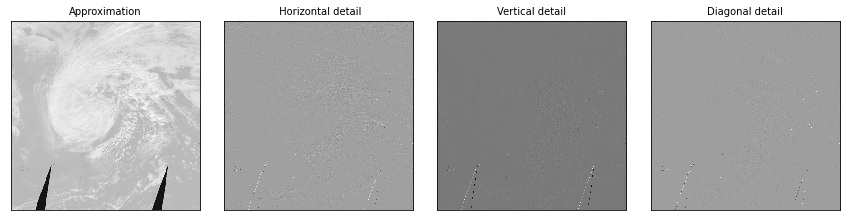

In [91]:
import pywt
print(R.shape)
#signal = loaded_image[2, :, :]
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
R_coeffs2 = pywt.dwt2(getTgtArea(R, -75.4, 40.3, 20), 'bior1.3')
G_coeffs2 = pywt.dwt2(getTgtArea(G, -75.4, 40.3, 20), 'bior1.3')
B_coeffs2 = pywt.dwt2(getTgtArea(B, -75.4, 40.3, 20), 'bior1.3')


R_LL, (R_LH, R_HL, R_HH) = R_coeffs2
G_LL, (G_LH, G_HL, G_HH) = G_coeffs2
B_LL, (B_LH, B_HL, B_HH) = B_coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([R_LL, R_LH, R_HL, R_HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


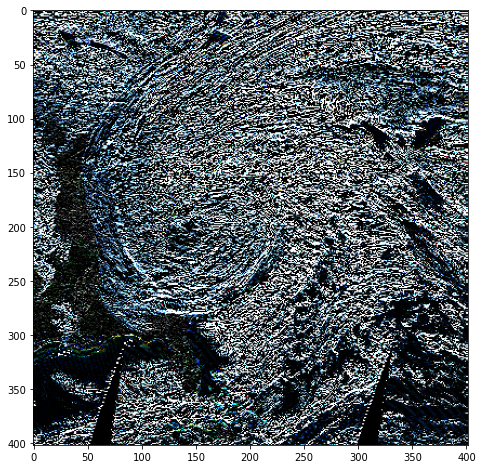

In [92]:

R_true = R_LH * 0.002
G_true = G_LH * 0.003
B_true = B_LH * 0.004

rgb = np.dstack([R_true, G_true, B_true])

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


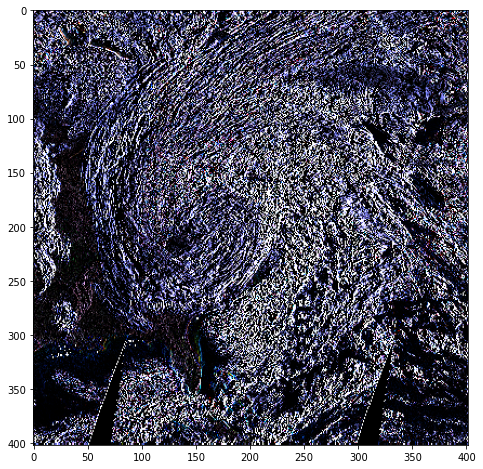

In [75]:

R_true = R_HL * 0.002
G_true = G_HL * 0.002
B_true = B_HL * 0.004

rgb = np.dstack([R_true, G_true, B_true])

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


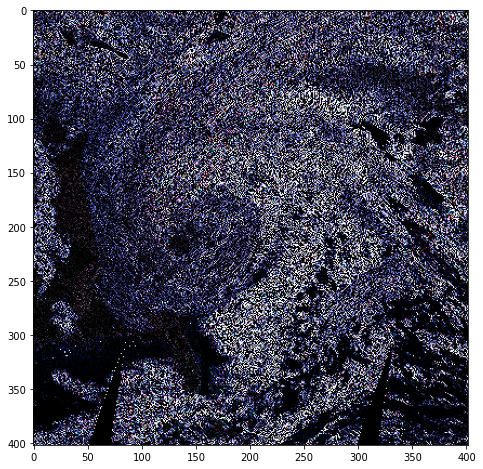

In [74]:

R_true = R_HH * 0.002
G_true = G_HH * 0.002
B_true = B_HH * 0.004

rgb = np.dstack([R_true, G_true, B_true])

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.show()

(402, 402)